# Monte Carlo Prediction - Policy Evaluation

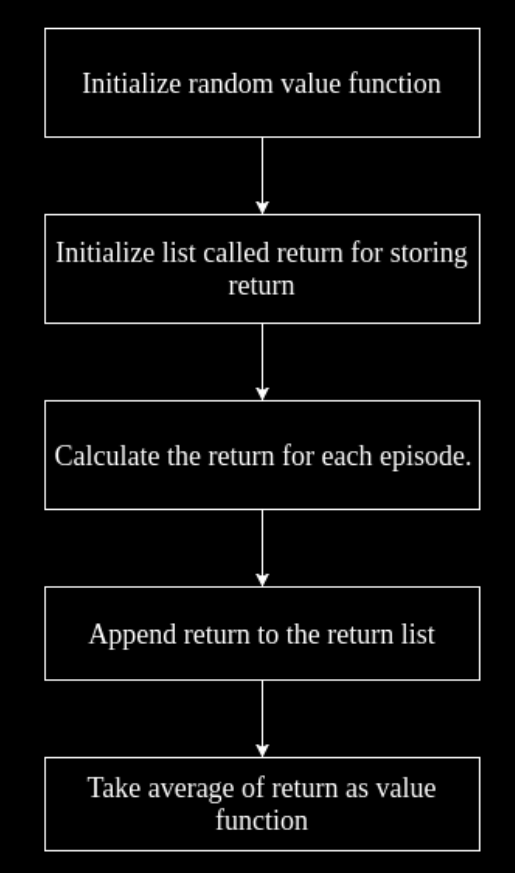

# STEP 1:  Run Episode

In [1]:
#Montecarlo Methods imply that you need to run n_episodes of random samples, we need to keep track of states and rewards as we do not have acess to the full enviroment.

In [3]:
#Load Required Packages and create the gym enviroment

import torch
import gym
env=gym.make('FrozenLake-v0')

In [27]:
#1.Define the function taking the environment and a random policy as inputs
def run_episode(env, policy):
    #2.Reset the enviroment to the iniciial position in this case, state=0
    state=env.reset()
    #3.Create an empty list of rewards so we can attach rewards of the following states
    rewards=[]
    #4.Create a list of states states=[state] gives mi a list of states starting in 0 (states=[0])
    states=[state]
    #5.is_done= False is the condition for the while loop to stop
    is_done=False
    #6.Looping over the states of the grid
    while not is_done:
    #7.The policy gives me the action I have to take at every state, then it takes the step an attaches the results to the lists   
        action=policy[state].item()
        state, reward, is_done, info=env.step(action)
        states.append(state)
        rewards.append(reward)
    #8.The condition at which the loop brakes
        if is_done:
            break
    #9.When the loop closes the result is a set of states and rewards
    states=torch.tensor(states)
    rewards=torch.tensor(rewards)
    return states, rewards

# STEP 2 : Option 1 - First Visit

In [28]:
#The goal is to obtain the 'Value Function' for the process without knowing transition probabilities and the reward data
# It uses only 

In [32]:
def mc_prediction_first_visit(env,policy,gamma, n_episodes):
    #1.Looks how many states the policy has. In the case the map is 16. In theory I can also use the same amount as the en.observations_space.n that we have used before
    n_state=policy.shape[0]
    #2.We create an empty Value vector that we are going to update with the results of the episodes
    V=torch.zeros(n_state)
    #3.The N vector is used to calculate the average of the value in a particular state. it basically says how many times has the agent stepped in a particular state given the policy
    N=torch.zeros(n_state)
    #4.We start by running episodes using the function we previously defined
    for episode in range(n_episode):
    #5.Results for episode i
        states_t , rewards_t = run_episode(env,policy)
    #6.We reset the return to 0. Remember return_t= (reward_t+1) + gamma*reward_t+2
        return_t=0
    #7.We create a first_visit Vector of ones and zeros that will capture were the agent  (What states the agents is in during the episode)
        first_visit=torch.zeros(n_state)
    #8.Create a Vector G that basically pastes all the calculated returns of the episode. 
        G=torch.zeros(n_state)
    #9.Now using the states_t and rewards_t , which we know are lists we start from the last episode to the first
    #10.VERY IMPORTANT: Notice that in this step state_t and reward_t are no longor lists but Value! so for State_t=15 fx  Rweard_t=1
    #11.PAY ATTENTION: The reversed states are IMPORTANT
        for state_t,reward_t in zip(reversed(states_t)[1:],reversed(rewards_t)):
    #12.For last_state --> return_t=reward_t ; penultimo_state--> return_t+1= reward_t+1 + gamma*return_t : ante_pulitimo-->>return_t+2=reward_t+2 + gamma(gamma*return_t)      
            return_t=reward_t+gamma*return_t
    #13.We paste the results in vector G and the end of all iteerations/
    #14.At the end is going to be something like this for example: G=( gamma15*reward_t,0 ,gamma2*reward_t   ,0,0,gamma*reward_t , reward_t)    
            G[state_t]=return_t
    #15.Places that we visit are replaced by 1.    
            first_visit[state_t]=1
    #16. After the loop is over with a First_vist vector of 1 and zeros stating where the agent has visited and the G_vector with the discounted rewards
        for state in range(n_state):
    #17.If the agent visits the state add the state to the value function        
            if first_visit[state]>0:
                V[state] += G[state]
                N[state] += 1
    #18.After adding to the value vector the result of the episode and the N vector which in the first round is just 1 and zeros and then it counts the number of times the agent has ben in a particular estate
    for state in range(n_state):
    #19.For only visited states we calculate the average of the reward(value function) after all of them being added. We omit the values that are 0 becase we dont want it to go infiinity    
        if N[state]>0:
            V[state]=V[state]/N[state]
    #20. We return our Value function
    return V
    

In [33]:
# Testing this aproach
gamma=1
n_episode=10000
#We use the ddynamic programming policy
optimal_policy=torch.tensor([0,3,3,3,0,3,2,3,3,1,0,3,3,2,1,3])


In [41]:
#Again just to clarify: Its called first visit prediction because it only uses the prediction
Value =mc_prediction_first_visit(env,optimal_policy,gamma,n_episode)
Value

tensor([0.7384, 0.5281, 0.5216, 0.4660, 0.7384, 0.0000, 0.3904, 0.0000, 0.7384,
        0.7392, 0.6684, 0.0000, 0.0000, 0.8022, 0.8886, 0.0000])

#  STEP 2 : Option 2 - Every Visit

In [46]:

def mc_prediction_every_visit(env,policy,gamma, n_episodes):
    #1.Looks how many states the policy has. In the case the map is 16. In theory I can also use the same amount as the en.observations_space.n that we have used before
    n_state=policy.shape[0]
    #2.We create an empty Value vector that we are going to update with the results of the episodes
    V=torch.zeros(n_state)
    #3.The N vector is used to calculate the average of the value in a particular state. it basically says how many times has the agent stepped in a particular state given the policy
    N=torch.zeros(n_state)
    #8.We initialize the G Vector for the returns only once. Before we start running all the episodes
    G=torch.zeros(n_state)
    #4.We start by running episodes using the function we previously defined
    for episode in range(n_episode):
    #5.Results for episode i
        states_t , rewards_t = run_episode(env,policy)
    #6.We reset the return to 0. Remember return_t= (reward_t+1) + gamma*reward_t+2
        return_t=0
    #7.Now using the states_t and rewards_t , which we know are lists we start from the last episode to the first
    #8.VERY IMPORTANT: Notice that in this step state_t and reward_t are no longor lists but Value! so for State_t=15 fx  Rweard_t=1
    #9.PAY ATTENTION: The reversed states are IMPORTANT
        for state_t,reward_t in zip(reversed(states_t)[1:],reversed(rewards_t)):
    #12.For last_state --> return_t=reward_t ; penultimo_state--> return_t+1= reward_t+1 + gamma*return_t : ante_pulitimo-->>return_t+2=reward_t+2 + gamma(gamma*return_t)      
            return_t=reward_t+gamma*return_t
    #13.We paste the results in vector G and the end of all iteerations in the same vector
    #14 it is almost the same as in the first visit case//
    #15.At the end is going to be something like this for example: G=( gamma15*reward_t,0 ,gamma2*reward_t   ,0,0,gamma*reward_t , reward_t)    
            G[state_t]+=return_t
            N[state_t]+=1
    for state in range(n_state):
    #19.For only visited states we calculate the average of the reward(value function) after all of them being added. We omit the values that are 0 becase we dont want it to go infiinity    
        if N[state]>0:
            V[state]=G[state]/N[state]
    #20. We return our Value function
    return V
    

In [47]:
value=mc_prediction_every_visit(env,optimal_policy,gamma,n_episode)
value

tensor([0.6214, 0.4181, 0.3895, 0.3755, 0.6230, 0.0000, 0.3661, 0.0000, 0.6406,
        0.6794, 0.6423, 0.0000, 0.0000, 0.7625, 0.8744, 0.0000])